In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data config
DATA_DIR = 'vesuvius-challenge-ink-detection'
BUFFER = 32
Z_DIM = 20
Z_START = 16
SHARED_HEIGHT = 4000

# Model config
BATCH_SIZE = 32
USE_MIXED_PRECISION = False
USE_JIT_COMPILE = False

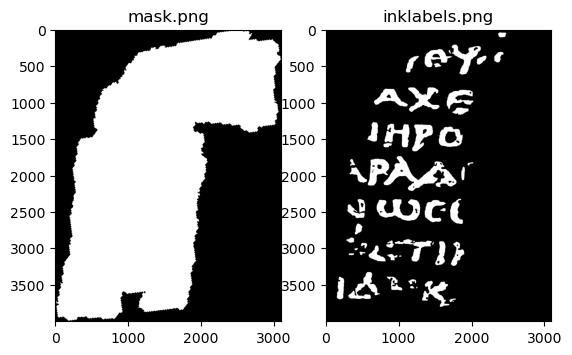

In [2]:
import torch
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import numpy as np

def resize(img):
    current_width, current_height = img.size
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    img = img.resize(new_size)
    return img

def load_mask(split, index):
    img = Image.open(f"{split}/{index}/mask.png").convert('1')
    img = resize(img)
    return torch.tensor(np.array(img), dtype=torch.bool)

def load_labels(split, index):
    img = Image.open(f"{split}/{index}/inklabels.png")
    img = resize(img)
    return torch.tensor(np.array(img), dtype=torch.bool)

mask = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()


In [3]:
mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index=1)
labels_train_1 = load_labels(split="train", index=1)

mask_train_2 = load_mask(split="train", index=2)
labels_train_2 = load_labels(split="train", index=2)

mask_train_3 = load_mask(split="train", index=3)
labels_train_3 = load_labels(split="train", index=3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

D:\anaconda\Lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


mask_test_a: torch.Size([4000, 9284])
mask_test_b: torch.Size([4000, 4642])
-
mask_train_1: torch.Size([4000, 3094])
labels_train_1: torch.Size([4000, 3094])
-
mask_train_2: torch.Size([4000, 2563])
labels_train_2: torch.Size([4000, 2563])
-
mask_train_3: torch.Size([4000, 2760])
labels_train_3: torch.Size([4000, 2760])


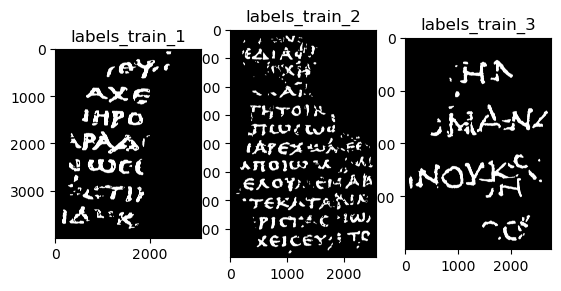

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1.cpu().numpy(), cmap='gray')  # Assuming labels_train_1 is on GPU, use .cpu() to move it to CPU

ax2.set_title("labels_train_2")
ax2.imshow(labels_train_2.cpu().numpy(), cmap='gray')  # Assuming labels_train_2 is on GPU, use .cpu() to move it to CPU

ax3.set_title("labels_train_3")
ax3.imshow(labels_train_3.cpu().numpy(), cmap='gray')  # Assuming labels_train_3 is on GPU, use .cpu() to move it to CPU

plt.show()


In [5]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    z_slices_fnames = sorted(glob.glob(f"{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = Image.open(filename)
        img = resize(img)
        z_slice = np.array(img, dtype="float32")
        z_slices.append(z_slice)
    return torch.stack([torch.from_numpy(z_slice) for z_slice in z_slices], dim=-1)

volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")



volume = volume_train_1
print(f"total volume: {volume.shape}")

# Optionally, delete variables to free up memory
del volume_train_1


20it [00:14,  1.38it/s]


volume_train_1: torch.Size([4000, 3094, 20]), torch.float32
total volume: torch.Size([4000, 3094, 20])


In [6]:
labels = labels_train_1
print(f"labels: {labels.shape}, {labels.dtype}")

mask = mask_train_1
print(f"mask: {mask.shape}, {mask.dtype}")

# Free up memory
del labels_train_1

del mask_train_1

labels: torch.Size([4000, 3094]), torch.bool
mask: torch.Size([4000, 3094]), torch.bool


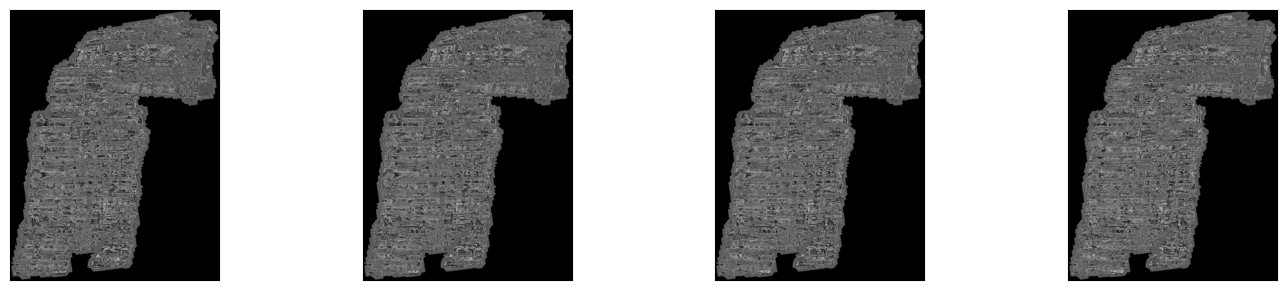

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for z, ax in enumerate(axes):
    ax.imshow(volume[:, :, z].cpu().numpy(), cmap='gray')  # Assuming volume is on GPU, use .cpu() to move it to CPU
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()


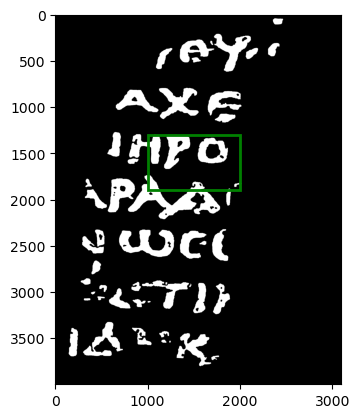

In [8]:
val_location = (1300, 1000)
val_zone_size = (600, 1000)

fig, ax = plt.subplots()
ax.imshow(labels.cpu().numpy(), cmap='gray')  # Assuming labels is on GPU, use .cpu() to move it to CPU
patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()


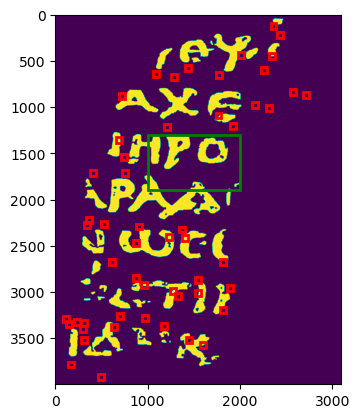

In [9]:
def sample_random_location(shape):
    random_train_x = torch.randint(low=BUFFER, high=shape[0]-BUFFER-1, size=(1, ), dtype=torch.int32)
    random_train_y = torch.randint(low=BUFFER, high=shape[1]-BUFFER-1, size=(1, ), dtype=torch.int32)
    randon_train_location = torch.stack([random_train_x, random_train_y])
    return randon_train_location

def is_in_mask_zone(location, mask):
    return mask[location[0], location[1]]

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[0]
    y = location[1]
    x_match = (val_location[0]-BUFFER <= x <= val_location[0]+val_zone_size[0]-BUFFER)
    y_match = (val_location[1]-BUFFER <= y <= val_location[1]+val_zone_size[1]-BUFFER)
    return x_match and y_match

def is_proper_train_location(location, val_location, val_zone_size, mask):
    return not is_in_val_zone(location, val_location, val_zone_size) and is_in_mask_zone(location, mask)

sample_train_location_train = lambda x: sample_random_location(mask.shape)
train_location_list = [sample_train_location_train(0) for _ in range(100)]
train_location_tensor = torch.stack(train_location_list)
train_location_ds = torch.utils.data.TensorDataset(train_location_tensor)
train_location_loader = torch.utils.data.DataLoader(train_location_ds, batch_size=1)
proper_train_location = []
for location in train_location_loader:
    location = location[0]
    location = location.squeeze()
    if is_proper_train_location(location, val_location, val_zone_size, mask):
        proper_train_location.append(location)
        
train_ds = torch.stack(proper_train_location)

fig, ax = plt.subplots()
ax.imshow(labels.cpu())

for x, y in train_ds.cpu():
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

In [10]:
def extract_subvolume(location, volume):
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :]
    subvolume = torch.tensor(subvolume, dtype=torch.float32) / 65535.
    return subvolume

def extract_labels(location, labels):
    x = location[0]
    y = location[1]
    label = labels[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER]
    label = torch.tensor(label, dtype=torch.float32)
    label = label.unsqueeze(dim=-1)
    return label

def extract_subvolume_and_label(location):
    subvolume = extract_subvolume(location, volume)
    label = extract_labels(location, labels)
    return subvolume, label

# Assuming train_ds is a PyTorch DataLoader, otherwise, you need to modify the dataset creation part
train_ds = DataLoader(train_location_ds, batch_size=1, shuffle=True)

# Assuming volume and labels are PyTorch tensors
for location_batch in train_ds:
    # Assuming the batch contains a single location tensor
    location = location_batch[0]
    location = location.squeeze()
    subvolume, label = extract_subvolume_and_label(location)
    print(f"subvolume shape: {subvolume.shape}")
    print(f"label shape: {label.shape}")


subvolume shape: torch.Size([64, 64, 20])
label shape: torch.Size([64, 64, 1])
subvolume shape: torch.Size([64, 64, 20])
label shape: torch.Size([64, 64, 1])
subvolume shape: torch.Size([64, 64, 20])
label shape: torch.Size([64, 64, 1])
subvolume shape: torch.Size([64, 64, 20])
label shape: torch.Size([64, 64, 1])
subvolume shape: torch.Size([64, 64, 20])
label shape: torch.Size([64, 64, 1])
subvolume shape: torch.Size([64, 64, 20])
label shape: torch.Size([64, 64, 1])
subvolume shape: torch.Size([64, 64, 20])
label shape: torch.Size([64, 64, 1])
subvolume shape: torch.Size([64, 64, 20])
label shape: torch.Size([64, 64, 1])
subvolume shape: torch.Size([64, 64, 20])
label shape: torch.Size([64, 64, 1])
subvolume shape: torch.Size([64, 64, 20])
label shape: torch.Size([64, 64, 1])
subvolume shape: torch.Size([64, 64, 20])
label shape: torch.Size([64, 64, 1])
subvolume shape: torch.Size([64, 64, 20])
label shape: torch.Size([64, 64, 1])
subvolume shape: torch.Size([64, 64, 20])
label shap

C:\Users\20965\AppData\Local\Temp\ipykernel_22380\2521582652.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  subvolume = torch.tensor(subvolume, dtype=torch.float32) / 65535.
C:\Users\20965\AppData\Local\Temp\ipykernel_22380\2521582652.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32)


In [11]:
import time

t0 = time.time()
n = 200

# Assuming train_ds is a PyTorch DataLoader
for _ in range(n):
    for batch in train_ds:
        # Access your data from the batch if needed
        # Example: subvolume, label = batch
        pass

print(f"Time per batch: {(time.time() - t0) / n:.4f}s")


Time per batch: 0.0076s


In [12]:
val_locations_stride = BUFFER
val_locations = []

# Generate validation locations
for x in range(val_location[0], val_location[0] + val_zone_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_zone_size[1], val_locations_stride):
        val_locations.append((x, y))

# Filter validation locations based on the mask
val_locations = [location for location in val_locations if is_in_mask_zone(location, mask)]

# Create a PyTorch DataLoader for validation
val_ds = [extract_subvolume_and_label(torch.tensor(location)) for location in val_locations]
val_ds = DataLoader(val_ds, batch_size=BATCH_SIZE)

# Print shapes of the first batch (assuming DataLoader returns batches similar to train_ds)
for subvolume, label in val_ds:
    print(f"Validation subvolume shape: {subvolume.shape}")
    print(f"Validation label shape: {label.shape}")
    break


C:\Users\20965\AppData\Local\Temp\ipykernel_22380\2521582652.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  subvolume = torch.tensor(subvolume, dtype=torch.float32) / 65535.
C:\Users\20965\AppData\Local\Temp\ipykernel_22380\2521582652.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32)


Validation subvolume shape: torch.Size([32, 64, 64, 20])
Validation label shape: torch.Size([32, 64, 64, 1])


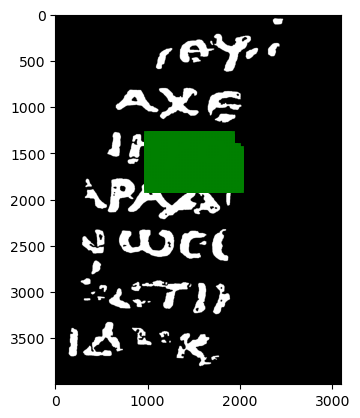

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(labels.cpu().numpy(), cmap='gray')  # Assuming labels is on GPU, use .cpu() to move it to CPU

for x, y in val_locations:
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(patch)

plt.show()


In [14]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.

    for _, batch_label in tqdm(dataset):
        matches += torch.sum(batch_label.float())
        total += torch.prod(torch.tensor(batch_label.shape, dtype=torch.float32))

    return 1. - matches / total.item()

# Assuming val_ds is a PyTorch DataLoader
score = trivial_baseline(val_ds)
print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")


100%|██████████| 19/19 [00:00<00:00, 361.87it/s]

Best validation score achievable trivially: 73.81% accuracy


In [15]:
augmenter = keras.([
    layers.RandomContrast(0.2),
])

def augment_train_data(data, label):
    data = augmenter(data)
    return data, label

augmented_train_ds = train_ds.map(augment_train_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

SyntaxError: invalid syntax (1917266884.py, line 1)